In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# To suppress numeric values from being returned in exponential format
pd.options.display.float_format = '{:20,.2f}'.format

# To display all charts against a white background
plt.style.use('seaborn-whitegrid')

### Step 1: A description of the data used in the project

InvestSure is a fictional investment company that manages the retirement accounts of its customers. It gets a dump of many data elements in CSV and JSON formats from transactional and external systems. The data that I have picked up for this project is a subset of all the data that is available. The company wants me to use this data and build a recommendation engine to suggest funds to its customers.

---

There are three main datasets in this project:
* **_Customers_**: This dataset contains details of the customers of InvestSure. There are approximately 21,000 customers in this dataset. The schema is described below:
    * _customer_id_: A monotonically increasing unique identifier for a customer
    * _first_name_: Customer's first name
    * _last_name_: Customer's last name
    * _city_: The city that the Customer lives in
    * _state_code_: The two character code of the state that the Customer lives in
    * _zip_: The zipcode of the Customer's address
    * _latitude_ and _longitude_: The geo-coordinates of the customer
    * _opportunity_: A numerical value that gives the total amount that the customer is willing to invest. This is recalculated daily based on the customer's total purchases over the entire history of the customer's interactions with the company.
* **_Mutual Funds_**: This dataset contains details of the Mutual Funds that the company offers to its customers for investing. There are approximately 24,000 mutual funds that the company carries on its investment platform. The details that are included are listed below:
    * _symbol_: The ticker symbol of the mutual fund
    * _name_: The name of the mutual fund
    * _init_inv_: The initial investment that the mutual fund requires when a customer first purchases it
    * _tna_: The Total Net Asset value of the fund. This is computed by the closing price of the mutual fund multiplied by the number of units of the fund that the fund company has sold.
    * _ytd_return_: An important metric, the Year-to-date Return indicates how much the mutual fund has returned to its investors in percentage terms. Negative values are possible and indicate a loss of capital.
    * _ms_rating_: Another crucial metric, this is the overall rating given to the fund by Morningstar,  a company that rates mutual funds on a scale of 1 to 5 with 5 being the highest. More details can be found here https://www.morningstar.com/company/morningstar-ratings-faq.
    * _inv_type_: This takes three possible values: Growth, Value and Blend. It indicates whether the primary purpose of the fund is capital appreciation, value increase or both. It plays an important role in the fund's evaluation.
    * _size_type_: This categorizes the fund into small, medium and large and indicates the size of the companies that the fund invests in based on their capitalization. This is another important metric that is used in evaluating funds.
    * _exp_ratio_: This is a numeric value that specifies how much the fund company charges investors for managing the fund. This is a crucial metric that helps investors decide whether to buy the fund or not. High expense ratios are generally avoided unless they are backed by above normal returns.
* _Transactions_: This dataset contains details of the customer's transactions. These are sales and redemptions of the fund (those two terms are used as viewed from InvestSure). There are approximately a million transactions in this dataset. The details that are captured are:
    * _txn_id_: A monotonically increasing integer value that uniquely identifies each transaction
    * _txn_date_: The date that the transaction took place. Useful for calculating trend analysis
    * _customer_id_: The Id of the Customer that created the transaction. Maps to a row in the Customer dataset above.
    * _symbol_: The ticker symbol of the fund against which the transaction is made. Maps to a row in the Mutual Funds dataset above.
    * _sales_: The sale value of the transaction if it is a fund sale
    * _redemptions_: The redemption value of the transaction if it is a liquidation of the whole or a part of the customer's holdings in a fund

### Step 2: Loading Data

In the following cells, this data is loaded into Pandas dataframes and some preliminary analyses is done on those datasets to look at their schema, sample data, size and some basic statistics.

In [63]:
df_customer = pd.read_csv('./data/customer.csv')

In [64]:
df_customer.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20951 entries, 0 to 20950
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  20951 non-null  int64  
 1   first_name   20951 non-null  object 
 2   last_name    20951 non-null  object 
 3   city         20951 non-null  object 
 4   state_code   15238 non-null  object 
 5   zip          20951 non-null  int64  
 6   country      20951 non-null  object 
 7   latitude     20951 non-null  float64
 8   longitude    20951 non-null  float64
 9   opportunity  20951 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 1.6+ MB


In [65]:
df_customer.head()

,customer_id,first_name,last_name,city,state_code,zip,country,latitude,longitude,opportunity
0,50037,Franklinc,Spango,San Juan,PR,917,USA,39.56,-119.49,30000
1,50038,Derrel,Cazzell,San Juan,PR,918,USA,18.47,-66.11,105000
2,50039,Mayrely,Deitel,San Juan,PR,918,USA,39.56,-119.49,10000
3,50040,Beena,Karpay,San Juan,PR,918,USA,39.56,-119.49,105000
4,50041,Malachi,Winik,San Juan,PR,918,USA,18.47,-66.11,105000


In [66]:
df_customer.shape

(20951, 10)

In [67]:
df_customer.describe()

,customer_id,zip,latitude,longitude,opportunity
count,"20,951.00","20,951.00","20,951.00","20,951.00","20,951.00"
mean,"60,512.00","47,072.54",38.23,-90.02,"97,642.59"
std,"6,048.18","30,158.87",5.14,16.19,"176,565.13"
min,"50,037.00",917.00,18.42,-157.94,"10,000.00"
25%,"55,274.50","19,428.00",34.15,-96.79,"20,000.00"
50%,"60,512.00","45,202.00",39.83,-85.14,"42,000.00"
75%,"65,749.50","75,240.00",41.68,-77.18,"90,000.00"
max,"70,987.00","99,901.00",64.85,-66.06,"3,049,000.00"


In [68]:
df_txn = pd.read_csv('data/txn.csv')

In [69]:
df_txn.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   txn_id       1048575 non-null  int64  
 1   txn_date     1048575 non-null  object 
 2   customer_id  1048575 non-null  int64  
 3   symbol       1048575 non-null  object 
 4   sales        1048575 non-null  float64
 5   redemptions  1048575 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 48.0+ MB


In [70]:
df_txn.head()

,txn_id,txn_date,customer_id,symbol,sales,redemptions
0,422909780,5/2/2016,59532,MLUYX,"13,687.83",0.00
1,422909781,5/2/2016,60660,PFJAX,0.00,"-4,286.23"
2,422909782,5/2/2016,52939,SBTAX,"4,153.98",0.00
3,422909783,5/2/2016,52990,MNMCX,"27,452.30",0.00
4,422909784,5/2/2016,60343,IDAEX,"6,433.14",0.00


In [71]:
df_txn.shape

(1048575, 6)

In [72]:
df_txn.describe()

,txn_id,customer_id,sales,redemptions
count,"1,048,575.00","1,048,575.00","1,048,575.00","1,048,575.00"
mean,"423,434,067.00","60,509.66","5,476.56","-2,413.16"
std,"302,697.67","6,045.63","7,183.11","3,153.61"
min,"422,909,780.00","50,037.00",0.00,"-12,821.61"
25%,"423,171,923.50","55,274.00",0.00,"-4,439.99"
50%,"423,434,067.00","60,512.00",0.00,-138.19
75%,"423,696,210.50","65,744.00","10,088.88",0.00
max,"423,958,354.00","70,987.00","29,186.85",0.00


In [73]:
df_mutual_fund = pd.read_json('data/mutual_fund.json')

In [74]:
df_mutual_fund.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23783 entries, 0 to 23782
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   symbol      23783 non-null  object 
 1   name        23783 non-null  object 
 2   init_inv    16485 non-null  float64
 3   tna         23749 non-null  float64
 4   ytd_return  23382 non-null  float64
 5   ms_rating   21976 non-null  float64
 6   inv_type    23783 non-null  object 
 7   size_type   23783 non-null  object 
 8   exp_ratio   23573 non-null  float64
dtypes: float64(5), object(4)
memory usage: 1.6+ MB


In [75]:
df_mutual_fund.head()

,symbol,name,init_inv,tna,ytd_return,ms_rating,inv_type,size_type,exp_ratio
0,AAAAX,DWS RREEF Real Assets Fund - Class A,"1,000.00","2,979,347,456.00",0.21,3.00,Value,Large,0.01
1,AAAEX,Virtus AllianzGI Health Sciences Fund Class P,"1,000,000.00","195,348,944.00",0.19,3.00,Blend,Large,0.01
2,AAAFX,American Century One Choice Blend+ 2015 Portfo...,"2,500.00","25,946.00",NaN,NaN,Blend,Large,0.01
3,AAAGX,Thrivent Large Cap Growth Fund Class A,"2,000.00","2,078,606,848.00",0.25,4.00,Growth,Large,0.01
4,AAAHX,American Century One Choice Blend+ 2015 Portfo...,"5,000,000.00","25,946.00",NaN,NaN,Blend,Large,0.00


In [76]:
df_mutual_fund.shape

(23783, 9)

In [77]:
df_mutual_fund.describe()

,init_inv,tna,ytd_return,ms_rating,exp_ratio
count,"16,485.00","23,749.00","23,382.00","21,976.00","23,573.00"
mean,"5,179,181.07","4,924,192,119.06",0.09,3.10,0.01
std,"92,535,840.22","21,097,646,505.29",0.08,1.08,0.01
min,10.00,10.00,-0.52,1.00,0.00
25%,"1,000.00","144,583,360.00",0.03,2.00,0.01
50%,"2,500.00","644,328,320.00",0.09,3.00,0.01
75%,"500,000.00","2,453,408,768.00",0.15,4.00,0.01
max,"5,000,000,000.00","753,410,000,000.00",0.58,5.00,0.12


### Step 3: Exploratory Data Analysis (EDA)

In the following cells, I will do some explorator data analysis of this data to get a better understanding of it. This also include some visualizations to bring out the relationships in the data.

##### 3.1. Sales and redemptions by customer


In [78]:
# Sales and redemptions by Customer - restricted to Top 10 by Sales
df_sales_by_cust = df_txn.groupby(['customer_id']).sum()[['sales', 'redemptions']].sort_values(by='sales', ascending=False).head(10)
print(df_sales_by_cust.head())
print()
print(df_sales_by_cust.shape[0])

                           sales          redemptions
customer_id                                          
66141                 576,984.37          -120,904.71
70941                 549,850.76          -147,380.24
58060                 540,494.96           -62,220.53
56531                 531,871.82           -59,766.72
52754                 527,923.92          -148,068.06

10


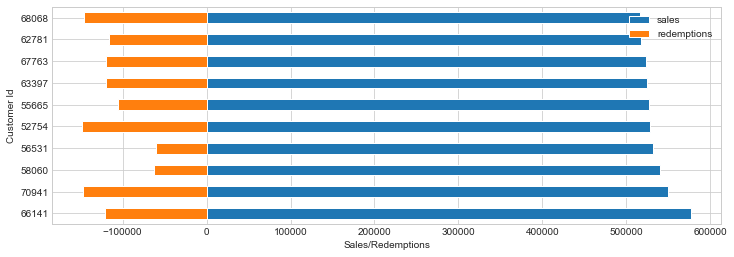

In [79]:
df_sales_by_cust.plot(kind='barh', stacked=True, figsize=(12, 4)).legend(loc='upper right')
plt.title='Sales and Redemptions by Customer'
plt.xlabel('Sales/Redemptions')
plt.ylabel('Customer Id');

##### 3.2. Sales and redemptions by mutual fund

In [80]:
# Sales and Redemptions by Top 10 Mutual Funds
df_sales_by_fund = df_txn.groupby(['symbol']).sum()[['sales', 'redemptions']].sort_values(by='sales', ascending=False).head(10)
print(df_sales_by_fund.head())
print()
print(df_sales_by_fund.shape[0])

                      sales          redemptions
symbol                                          
FLTNX          6,248,339.41        -2,341,594.79
PCIEX          6,191,035.99        -2,189,045.14
QDVAX          6,178,711.28        -2,172,017.89
BHTAX          6,161,544.85        -2,392,624.24
MWHIX          6,140,072.28        -2,517,185.55

10


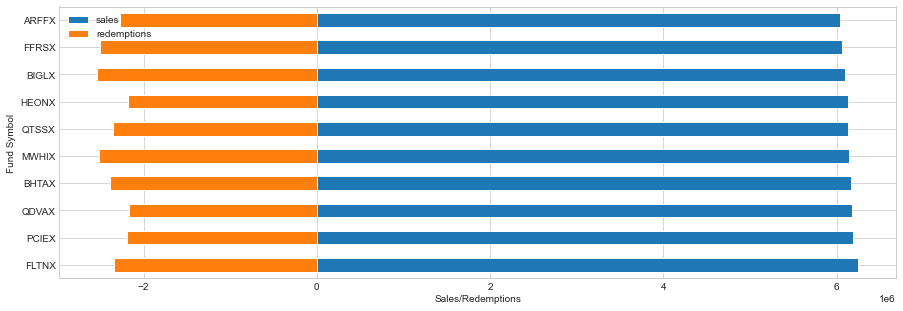

In [81]:
df_sales_by_fund.plot(kind='barh', stacked=True, figsize=(15, 5)).legend(loc='upper left')
plt.title='Sales and Redemptions by Customer'
plt.xlabel('Sales/Redemptions')
plt.ylabel('Fund Symbol');


##### 3.3. Sales and redemptions by customer and mutual fund

In [82]:
df_sales_by_cust_fund = df_txn.groupby(['customer_id', 'symbol']).sum()[['sales', 'redemptions']].sort_values(by=['customer_id', 'symbol', 'sales'], ascending=False)
print(df_sales_by_cust_fund.head(10))
print()
print(df_sales_by_cust_fund.shape[0])

                                  sales          redemptions
customer_id symbol                                          
70987       WMGYX                  0.00            -3,087.45
            WIPDX                  0.00            -3,073.60
            WEBCX                  0.00            -5,021.45
            VAFIX                  0.00            -3,508.27
            TIRTX                  0.00            -5,417.76
            TFICX              3,478.04                 0.00
            STIIX                  0.00            -8,109.27
            SMVIX                  0.00            -5,351.73
            SCACX                  0.00            -7,923.22
            RRRCX              7,093.25                 0.00

1024379


##### 3.4. A deeper look at fund attribute-based aggregations

In [83]:
# Sales and redemptions by MS Rating
df_sales_by_ms_rating = pd.merge(left=df_txn, right=df_mutual_fund, on='symbol')[['ms_rating', 'sales', 'redemptions']].groupby(['ms_rating']).sum([['sales', 'redemptions']])
df_sales_by_ms_rating.head()

,sales,redemptions
ms_rating,,
1.00,"416,731,076.75","-182,380,291.36"
2.00,"1,115,395,346.56","-488,298,069.38"
3.00,"1,925,941,821.92","-852,113,551.55"
4.00,"1,244,727,914.45","-551,192,333.21"
5.00,"645,653,867.87","-282,338,630.75"


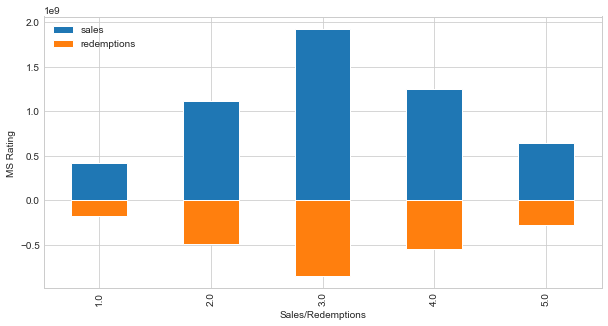

In [84]:
df_sales_by_ms_rating.plot(kind='bar', stacked=True, figsize=(10, 5)).legend(loc='upper left')
plt.title='Sales and Redemptions by Morning Star Rating'
plt.xlabel('Sales/Redemptions')
plt.ylabel('MS Rating');

In [85]:
# Sales and redemptions by Size
df_sales_by_size = pd.merge(left=df_txn, right=df_mutual_fund, on='symbol')[['size_type', 'sales', 'redemptions']].groupby(['size_type']).sum([['sales', 'redemptions']])
df_sales_by_size.head()

,sales,redemptions
size_type,,
,"231,448,620.94","-103,682,807.62"
Large,"3,238,479,565.16","-1,428,503,590.47"
Medium,"1,277,880,470.13","-562,240,701.15"
Small,"994,775,352.21","-435,948,285.12"


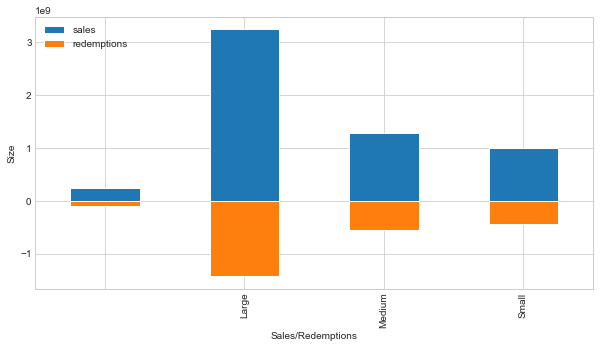

In [86]:
df_sales_by_size.plot(kind='bar', stacked=True, figsize=(10, 5)).legend(loc='upper left')
plt.title='Sales and Redemptions by Size'
plt.xlabel('Sales/Redemptions')
plt.ylabel('Size');

##### 3.5. A deeper look at customer attribute-based aggregations

In [87]:
# Sales and redemptions by Customer
df_sales_by_cust_opp = pd.merge(left=df_txn, right=df_customer, on='customer_id')[['customer_id', 'opportunity', 'sales', 'redemptions']].groupby(['customer_id', 'opportunity']).sum([['sales', 'redemptions']])
df_sales_by_cust_opp.head()

,,sales,redemptions
customer_id,opportunity,,
50037,30000,"306,751.44","-155,164.77"
50038,105000,"361,158.77","-96,853.36"
50039,10000,"426,594.74","-139,711.70"
50040,105000,"244,707.71","-74,396.43"
50041,105000,"293,969.41","-106,756.21"


In [88]:
# Sales and redemptions by geographic location
df_sales_by_state = pd.merge(left=df_txn, right=df_customer, on='customer_id')[['state_code', 'sales', 'redemptions']].groupby(['state_code']).sum([['sales', 'redemptions']]).sort_values(by='sales', ascending=False)
df_sales_by_state.head()

,sales,redemptions
state_code,,
NY,"567,524,392.44","-246,541,075.36"
FL,"375,786,466.08","-168,560,917.47"
PA,"276,170,949.21","-123,118,853.75"
IL,"265,259,071.56","-116,787,205.17"
NJ,"246,652,189.70","-106,748,488.73"


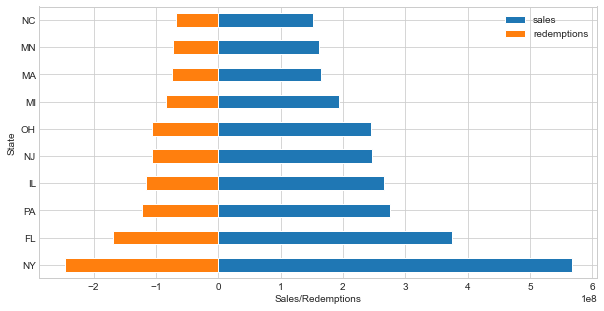

In [89]:
df_sales_by_state.head(10).plot(kind='barh', stacked=True, figsize=(10, 5)).legend(loc='upper right')
plt.title='Sales and Redemptions by State'
plt.xlabel('Sales/Redemptions')
plt.ylabel('State');

### Step 4: Feature Engineering

In this section, I would like to identify the various features that we can pull out of this data to help us build recommendations. I will classify these features based on the dataset below:

###### Mutual Funds
1. **Morningstar Rating**: This is ranking given to publicly traded mutual funds and exchange traded funds by the investment research firm Morningstar. Risk is assessed at five levels designed to help investors quickly identify funds to consider for their portfolios. More information can be found at https://www.investopedia.com/terms/m/morningstarriskrating.asp. In general, funds with a rating of 4 and 5 are highly sought after. They may be considered as Strong Buys. Funds with a rating of 1 or 2 may be considered Strong Sells while those with a rating of 3 may be considered as Hold.
2. **Size Type**: Broadly classified into three categories (Small, Medium and Large), this indicates the sizes of the companies in which the Mutual Fund invests.
3. **Expense Ratio**: This is a continuous numeric value and is not much useful to us as it is. However, we can broadly classify these into three categories - Low: less than 0.5%, Reasonable: between 0.5% and 1% and High: above 1%.
4. **Initial Investment**: This is a continuous numeric value; however, we can classify these values as Low (<= 1,000), Medium (> 1000 and <= 100,000) and High (> 100,000)
5. **Year-to-date Return**: The Year-to-date Return is a critical metric to assessing whether to pick a Mutual Fund or not. This is also a continuous numeric value; however, we can classify these values as Negative (< 0), Low (> 0 and <= 5), Moderate (> 5 and <= 10) and High (> 10)
6. **Investment Type**: This is a categorical value and is one of Growth, Value or Blend. It indicates whether the main purpose of the fund is to provide growth, value or both.

##### Customers
7. **Opportunity**: This is also a continuous numeric value and indicates the amount upto which a customer may be willing to invest. This is assessed daily and set to the maximum value of sales for a given customer over the entire history of the customer's relationship with the investment company. While the amount is not very useful in itself for our purpose, we can engineer it as a metric to indicate whether a sale is possible. To make that assessment, we could say that a sale is possible if the total sales of a given customer is less than 75% of the opportunity marked against that customer. When recommending funds to a customer, we can take this metric into account as well.

#### Transactions
8. **Net Sales**: This is the total sales of a given customer of a given fund after deducting redemptions from the same. We could impute that a positive number (preferably subject to a minimum threshold) indicates that the customer recommends that product. Otherwise, not.

In the following cells, I will turn these features into 1 and 0 value matrices that we can later use to build out our recommendations.

##### 4.1: Add necessary columns to the datasets as per discussion above containing 0 and 1 values

###### 4.1.1: Adding features to Mutual Funds

In [90]:
# Extracting features for Mutual Funds
# Using MS Ratings higher than 3 to set a new column named 'buy' to 1 and 0 otherwise
# First, let us sat NaN values to 0 to indicate that they are not rated
df_mutual_fund['ms_rating'].fillna(value=0, inplace=True)

# Add a new column to the Mutual Fund dataset named 'buy' and set it to 0 or 1 values
df_mutual_fund['buy'] = (df_mutual_fund['ms_rating'] > 3).astype(int)
df_mutual_fund.head()

,symbol,name,init_inv,tna,ytd_return,ms_rating,inv_type,size_type,exp_ratio,buy
0,AAAAX,DWS RREEF Real Assets Fund - Class A,"1,000.00","2,979,347,456.00",0.21,3.00,Value,Large,0.01,0
1,AAAEX,Virtus AllianzGI Health Sciences Fund Class P,"1,000,000.00","195,348,944.00",0.19,3.00,Blend,Large,0.01,0
2,AAAFX,American Century One Choice Blend+ 2015 Portfo...,"2,500.00","25,946.00",NaN,0.00,Blend,Large,0.01,0
3,AAAGX,Thrivent Large Cap Growth Fund Class A,"2,000.00","2,078,606,848.00",0.25,4.00,Growth,Large,0.01,1
4,AAAHX,American Century One Choice Blend+ 2015 Portfo...,"5,000,000.00","25,946.00",NaN,0.00,Blend,Large,0.00,0


In [91]:
# Using the values in Size column to set new columns named Small, Medium and Large to 0 and 1 values
df_mutual_fund['small'] = (df_mutual_fund['size_type'] == 'Small').astype(int)
df_mutual_fund['medium'] = (df_mutual_fund['size_type'] == 'Medium').astype(int)
df_mutual_fund['large'] = (df_mutual_fund['size_type'] == 'Large').astype(int)
df_mutual_fund.head()

,symbol,name,init_inv,tna,ytd_return,ms_rating,inv_type,size_type,exp_ratio,buy,small,medium,large
0,AAAAX,DWS RREEF Real Assets Fund - Class A,"1,000.00","2,979,347,456.00",0.21,3.00,Value,Large,0.01,0,0,0,1
1,AAAEX,Virtus AllianzGI Health Sciences Fund Class P,"1,000,000.00","195,348,944.00",0.19,3.00,Blend,Large,0.01,0,0,0,1
2,AAAFX,American Century One Choice Blend+ 2015 Portfo...,"2,500.00","25,946.00",NaN,0.00,Blend,Large,0.01,0,0,0,1
3,AAAGX,Thrivent Large Cap Growth Fund Class A,"2,000.00","2,078,606,848.00",0.25,4.00,Growth,Large,0.01,1,0,0,1
4,AAAHX,American Century One Choice Blend+ 2015 Portfo...,"5,000,000.00","25,946.00",NaN,0.00,Blend,Large,0.00,0,0,0,1


In [92]:
# Using Expense Ratio values to add new columns named "er_low', 'er_medium' and 'er_high'
# First let us set all NaN values to zero which is a reasonable replacement; if an expense ration is not available, we can consider it to be 0
df_mutual_fund['exp_ratio'].fillna(value=0, inplace=True)

# Add the new columns
df_mutual_fund['er_low'] = (df_mutual_fund['exp_ratio'] * 100 < 0.5).astype(int)
df_mutual_fund['er_medium'] = (np.logical_and(df_mutual_fund['exp_ratio'] * 100 >= 0.5, df_mutual_fund['exp_ratio'] * 100 <= 1.0)).astype(int)
df_mutual_fund['er_high'] = (df_mutual_fund['exp_ratio'] * 100 > 1.0).astype(int)
df_mutual_fund.head()

,symbol,name,init_inv,tna,ytd_return,ms_rating,inv_type,size_type,exp_ratio,buy,small,medium,large,er_low,er_medium,er_high
0,AAAAX,DWS RREEF Real Assets Fund - Class A,"1,000.00","2,979,347,456.00",0.21,3.00,Value,Large,0.01,0,0,0,1,0,0,1
1,AAAEX,Virtus AllianzGI Health Sciences Fund Class P,"1,000,000.00","195,348,944.00",0.19,3.00,Blend,Large,0.01,0,0,0,1,0,0,1
2,AAAFX,American Century One Choice Blend+ 2015 Portfo...,"2,500.00","25,946.00",NaN,0.00,Blend,Large,0.01,0,0,0,1,0,1,0
3,AAAGX,Thrivent Large Cap Growth Fund Class A,"2,000.00","2,078,606,848.00",0.25,4.00,Growth,Large,0.01,1,0,0,1,0,0,1
4,AAAHX,American Century One Choice Blend+ 2015 Portfo...,"5,000,000.00","25,946.00",NaN,0.00,Blend,Large,0.00,0,0,0,1,1,0,0


In [93]:
# Using Initial Investment values to add new columns named "init_inv_low", "init_inv_med", "init_inv_high"
# First, let us set all NaN values to zero which is an acceptable replacement. If no initial investment requirement is specified, it means that it is left to the discretion of the investor
df_mutual_fund['init_inv'].fillna(value=0, inplace=True)

# Add the new columns
df_mutual_fund['init_inv_low'] = (df_mutual_fund['init_inv'] <= 1000).astype(int)
df_mutual_fund['init_inv_medium'] = (np.logical_and(df_mutual_fund['init_inv'] > 1000, df_mutual_fund['init_inv'] <= 100000)).astype(int)
df_mutual_fund['init_inv_high'] = (df_mutual_fund['init_inv'] > 100000).astype(int)
df_mutual_fund.head()

,symbol,name,init_inv,tna,ytd_return,ms_rating,inv_type,size_type,exp_ratio,buy,small,medium,large,er_low,er_medium,er_high,init_inv_low,init_inv_medium,init_inv_high
0,AAAAX,DWS RREEF Real Assets Fund - Class A,"1,000.00","2,979,347,456.00",0.21,3.00,Value,Large,0.01,0,0,0,1,0,0,1,1,0,0
1,AAAEX,Virtus AllianzGI Health Sciences Fund Class P,"1,000,000.00","195,348,944.00",0.19,3.00,Blend,Large,0.01,0,0,0,1,0,0,1,0,0,1
2,AAAFX,American Century One Choice Blend+ 2015 Portfo...,"2,500.00","25,946.00",NaN,0.00,Blend,Large,0.01,0,0,0,1,0,1,0,0,1,0
3,AAAGX,Thrivent Large Cap Growth Fund Class A,"2,000.00","2,078,606,848.00",0.25,4.00,Growth,Large,0.01,1,0,0,1,0,0,1,0,1,0
4,AAAHX,American Century One Choice Blend+ 2015 Portfo...,"5,000,000.00","25,946.00",NaN,0.00,Blend,Large,0.00,0,0,0,1,1,0,0,0,0,1


In [94]:
# Using Year-to-date Return values to add new columns named "low", "moderate" and "high"
# First, let us set all NaN values to zero which is a generally acceptable replacement. No YTD Return value may be available for the fund
df_mutual_fund['ytd_return'].fillna(value=0, inplace=True)

# Add the new columns
df_mutual_fund['ytd_low'] = (np.logical_and(df_mutual_fund['ytd_return'] > 0, df_mutual_fund['ytd_return'] <= 0.05)).astype(int)
df_mutual_fund['ytd_moderate'] = (np.logical_and(df_mutual_fund['ytd_return'] > 0.05, df_mutual_fund['ytd_return'] <= 0.1)).astype(int)
df_mutual_fund['ytd_high'] = (df_mutual_fund['ytd_return'] > 0.1).astype(int)
df_mutual_fund.head()

,symbol,name,init_inv,tna,ytd_return,ms_rating,inv_type,size_type,exp_ratio,buy,...,large,er_low,er_medium,er_high,init_inv_low,init_inv_medium,init_inv_high,ytd_low,ytd_moderate,ytd_high
0,AAAAX,DWS RREEF Real Assets Fund - Class A,"1,000.00","2,979,347,456.00",0.21,3.00,Value,Large,0.01,0,...,1,0,0,1,1,0,0,0,0,1
1,AAAEX,Virtus AllianzGI Health Sciences Fund Class P,"1,000,000.00","195,348,944.00",0.19,3.00,Blend,Large,0.01,0,...,1,0,0,1,0,0,1,0,0,1
2,AAAFX,American Century One Choice Blend+ 2015 Portfo...,"2,500.00","25,946.00",0.00,0.00,Blend,Large,0.01,0,...,1,0,1,0,0,1,0,0,0,0
3,AAAGX,Thrivent Large Cap Growth Fund Class A,"2,000.00","2,078,606,848.00",0.25,4.00,Growth,Large,0.01,1,...,1,0,0,1,0,1,0,0,0,1
4,AAAHX,American Century One Choice Blend+ 2015 Portfo...,"5,000,000.00","25,946.00",0.00,0.00,Blend,Large,0.00,0,...,1,1,0,0,0,0,1,0,0,0


In [95]:
# Using Investment Type values to add new columns named "growth", "value" and "blend"
df_mutual_fund['growth'] = (df_mutual_fund['inv_type'] == 'Growth').astype(int)
df_mutual_fund['value'] = (df_mutual_fund['inv_type'] == 'Value').astype(int)
df_mutual_fund['blend'] = (df_mutual_fund['inv_type'] == 'Blend').astype(int)
df_mutual_fund.head()

,symbol,name,init_inv,tna,ytd_return,ms_rating,inv_type,size_type,exp_ratio,buy,...,er_high,init_inv_low,init_inv_medium,init_inv_high,ytd_low,ytd_moderate,ytd_high,growth,value,blend
0,AAAAX,DWS RREEF Real Assets Fund - Class A,"1,000.00","2,979,347,456.00",0.21,3.00,Value,Large,0.01,0,...,1,1,0,0,0,0,1,0,1,0
1,AAAEX,Virtus AllianzGI Health Sciences Fund Class P,"1,000,000.00","195,348,944.00",0.19,3.00,Blend,Large,0.01,0,...,1,0,0,1,0,0,1,0,0,1
2,AAAFX,American Century One Choice Blend+ 2015 Portfo...,"2,500.00","25,946.00",0.00,0.00,Blend,Large,0.01,0,...,0,0,1,0,0,0,0,0,0,1
3,AAAGX,Thrivent Large Cap Growth Fund Class A,"2,000.00","2,078,606,848.00",0.25,4.00,Growth,Large,0.01,1,...,1,0,1,0,0,0,1,1,0,0
4,AAAHX,American Century One Choice Blend+ 2015 Portfo...,"5,000,000.00","25,946.00",0.00,0.00,Blend,Large,0.00,0,...,0,0,0,1,0,0,0,0,0,1


###### 4.1.2: Adding features to Customer

In [96]:
# Extracting features for Customer
# Use the 'opportunity' data and set a new column with 1 if the total sales of a customer is less than 75% of the opportunity value for that customer
# Otherwise, set it to 0

df_cust_tmp = pd.merge(df_txn.groupby('customer_id').sum()['sales'].reset_index(), df_customer, on='customer_id')[['customer_id', 'sales', 'opportunity']]
df_customer['sale_opportunity'] = (df_cust_tmp['sales'] * .75 < df_cust_tmp['opportunity']).astype(int)

In [97]:
df_customer.head()

,customer_id,first_name,last_name,city,state_code,zip,country,latitude,longitude,opportunity,sale_opportunity
0,50037,Franklinc,Spango,San Juan,PR,917,USA,39.56,-119.49,30000,0
1,50038,Derrel,Cazzell,San Juan,PR,918,USA,18.47,-66.11,105000,0
2,50039,Mayrely,Deitel,San Juan,PR,918,USA,39.56,-119.49,10000,0
3,50040,Beena,Karpay,San Juan,PR,918,USA,39.56,-119.49,105000,0
4,50041,Malachi,Winik,San Juan,PR,918,USA,18.47,-66.11,105000,0


###### 4.1.3: Adding features to Transactions

In [98]:
# Extracting features for Transactions
# Use the net sales value (Sales - Redemptions) grouped by fund to set a new column titled 'fund_recommended' to 1 if net sales > 250,000; 0 otherwise
df_txn_tmp = (df_txn.groupby('symbol').sum()['sales'] + df_txn.groupby('symbol').sum()['redemptions']).to_frame().reset_index()
df_txn_tmp.columns = ['symbol', 'net_sales']
df_txn['fund_recommended'] = (df_txn_tmp['net_sales'] > 250000).astype(int)
df_txn['fund_recommended'] = df_txn['fund_recommended'].fillna(value=0).astype(int)
df_txn.head(10)

,txn_id,txn_date,customer_id,symbol,sales,redemptions,fund_recommended
0,422909780,5/2/2016,59532,MLUYX,"13,687.83",0.00,1
1,422909781,5/2/2016,60660,PFJAX,0.00,"-4,286.23",1
2,422909782,5/2/2016,52939,SBTAX,"4,153.98",0.00,1
3,422909783,5/2/2016,52990,MNMCX,"27,452.30",0.00,1
4,422909784,5/2/2016,60343,IDAEX,"6,433.14",0.00,1
5,422909785,5/2/2016,66341,CEUCX,"1,124.98",0.00,1
6,422909786,5/2/2016,65708,QMLFX,0.00,"-6,891.62",1
7,422909787,5/2/2016,52204,FAVTX,0.00,"-4,252.69",1
8,422909788,5/2/2016,54242,JDVRX,"11,588.50",0.00,1
9,422909789,5/2/2016,57716,MSFAX,"9,011.30",0.00,1


###### 4.1.4: Create a Customer-Mutual Fund Interactions dataset from the Transactions dataset

In [99]:
# Create a Customer-Mutual Fund interaction dataset from df_txn
df_cust_fund_interactions = df_txn[['customer_id', 'symbol', 'fund_recommended']].drop_duplicates()

In [100]:
df_cust_fund_interactions.head()

,customer_id,symbol,fund_recommended
0,59532,MLUYX,1
1,60660,PFJAX,1
2,52939,SBTAX,1
3,52990,MNMCX,1
4,60343,IDAEX,1


##### 4.2: Create the necessary matrices with the above data

###### 4.2.1: Defining a function to create a generic feature matrix

In [101]:
def create_feature_matrix(df, index, column, value, fill_na_val=0):
    """
    A function that accepts a source dataframe and creates a 1/0 value feature matrix out of it based on inputs
    It fills NaN values with the fill_na_val parameter passed in
    :param df: (pandas.core.frame.DataFrame) source dataframe that contains the data
    :param index: (str) the column that should be used as row header in the matrix
    :param column: (str) the column that should be pivoted as multiple columns
    :param value: (str) the column that contains the values for the pivoted columns
    :param fill_na_val: (int) defaults to 0
    :return: (pandas.core.frame.DataFrame) the dataframe containing the matrix
    """

    try:
        matrix = df.pivot(index=index, columns=column, values=value).fillna(value=fill_na_val)
    except ValueError:
        # In case the pivot method throws an exception, try the pivot_table method
        matrix = df.pivot_table(index=index, columns=column, values=value, aggfunc='sum').fillna(value=fill_na_val)

    # Downcast all numeric values to int so that the features can have the values 0 or 1
    matrix = matrix.apply(pd.to_numeric, errors='ignore', downcast='integer')

    return matrix

###### 4.2.2: Create a matrix to hold Customer-Fund Buy values

In [102]:
input_df = pd.merge(df_cust_fund_interactions, df_mutual_fund, on='symbol')[['customer_id', 'symbol', 'buy']].drop_duplicates()
df_cust_fund_buy_matrix = create_feature_matrix(input_df, 'customer_id', 'symbol', 'buy')

In [103]:
df_cust_fund_buy_matrix.head()

symbol,AABYX,AAMBX,AAUTX,ABNDX,ABQUX,ABTZX,ABYAX,ACCWX,ACEIX,ACEVX,...,WMMAX,WPRSX,WRGCX,WSHFX,WSIDX,WSMAX,WTABX,WUSNX,WWIDX,YASLX
customer_id,,,,,,,,,,,,,,,,,,,,,
50037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### 4.2.3: Crate matrices to hold Customer-Fund Size values - one each for small, medium and large

In [104]:
df_cust_fund_size = pd.merge(df_cust_fund_interactions, df_mutual_fund, on='symbol')[['customer_id', 'symbol', 'small', 'medium', 'large']].drop_duplicates()

In [105]:
df_cust_fund_size.head()

,customer_id,symbol,small,medium,large
0,59532,MLUYX,0,1,0
1,64981,MLUYX,0,1,0
2,59521,MLUYX,0,1,0
3,61570,MLUYX,0,1,0
4,59414,MLUYX,0,1,0


In [106]:
df_cust_fund_small_matrix = create_feature_matrix(df_cust_fund_size, 'customer_id', 'symbol', 'small')
df_cust_fund_medium_matrix = create_feature_matrix(df_cust_fund_size, 'customer_id', 'symbol', 'medium')
df_cust_fund_large_matrix = create_feature_matrix(df_cust_fund_size, 'customer_id', 'symbol', 'large')

In [107]:
print(df_cust_fund_small_matrix.head())
print(df_cust_fund_medium_matrix.head())
print(df_cust_fund_large_matrix.head())

symbol       AABYX  AAMBX  AAUTX  ABNDX  ABQUX  ABTZX  ABYAX  ACCWX  ACEIX  \
customer_id                                                                  
50037            0      0      0      0      0      0      0      0      0   
50038            0      0      0      0      0      0      0      0      0   
50039            0      0      0      0      0      0      0      0      0   
50040            0      0      0      0      0      0      0      0      0   
50041            0      0      0      0      0      0      0      0      0   

symbol       ACEVX  ...  WMMAX  WPRSX  WRGCX  WSHFX  WSIDX  WSMAX  WTABX  \
customer_id         ...                                                    
50037            0  ...      0      0      0      0      0      0      0   
50038            0  ...      1      0      0      0      0      0      0   
50039            0  ...      0      0      0      0      0      0      0   
50040            0  ...      0      0      0      0      0      0      0 

###### 4.2.4: Crate a matrix to hold Customer-Fund Expense Ratio values - one each for low, medium and high

In [108]:
df_cust_fund_er = pd.merge(df_cust_fund_interactions, df_mutual_fund, on='symbol')[['customer_id', 'symbol', 'er_low', 'er_medium', 'er_high']].drop_duplicates()

In [109]:
df_cust_fund_er.head()

,customer_id,symbol,er_low,er_medium,er_high
0,59532,MLUYX,0,1,0
1,64981,MLUYX,0,1,0
2,59521,MLUYX,0,1,0
3,61570,MLUYX,0,1,0
4,59414,MLUYX,0,1,0


In [110]:
df_cust_fund_er_low_matrix = create_feature_matrix(df_cust_fund_er, 'customer_id', 'symbol', 'er_low')
df_cust_fund_er_medium_matrix = create_feature_matrix(df_cust_fund_er, 'customer_id', 'symbol', 'er_medium')
df_cust_fund_er_high_matrix = create_feature_matrix(df_cust_fund_er, 'customer_id', 'symbol', 'er_high')

In [111]:
print(df_cust_fund_er_low_matrix.head())
print(df_cust_fund_er_medium_matrix.head())
print(df_cust_fund_er_high_matrix.head())

symbol       AABYX  AAMBX  AAUTX  ABNDX  ABQUX  ABTZX  ABYAX  ACCWX  ACEIX  \
customer_id                                                                  
50037            0      0      0      0      0      0      0      0      0   
50038            0      0      0      0      0      0      0      0      0   
50039            0      0      0      0      0      0      0      0      0   
50040            0      0      0      0      0      0      0      0      0   
50041            0      0      0      0      0      0      0      0      0   

symbol       ACEVX  ...  WMMAX  WPRSX  WRGCX  WSHFX  WSIDX  WSMAX  WTABX  \
customer_id         ...                                                    
50037            0  ...      0      0      0      0      0      0      0   
50038            0  ...      0      0      0      0      0      0      0   
50039            0  ...      0      0      0      0      0      0      0   
50040            0  ...      0      0      0      0      0      0      0 

###### 4.2.5: Crate a matrix to hold Customer-Fund Sale Opportunity

In [112]:
input_df = pd.merge(df_cust_fund_interactions, df_customer, on='customer_id')[['customer_id', 'symbol', 'sale_opportunity']].drop_duplicates()
df_cust_fund_sale_matrix = create_feature_matrix(input_df, 'customer_id', 'symbol', 'sale_opportunity')

In [113]:
df_cust_fund_sale_matrix.head()

symbol,AABYX,AAMBX,AAUTX,ABNDX,ABQUX,ABTZX,ABYAX,ACCWX,ACEIX,ACEVX,...,WMMAX,WPRSX,WRGCX,WSHFX,WSIDX,WSMAX,WTABX,WUSNX,WWIDX,YASLX
customer_id,,,,,,,,,,,,,,,,,,,,,
50037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### 4.2.6: Crate a matrix to hold Customer-Fund Recommendation based on high net sales

In [114]:
# input_df = df_cust_fund_interactions.pivot_table(index='customer_id', columns='symbol', values='fund_recommended', aggfunc='sum').fillna(value=0)
df_cust_fund_rec_matrix = create_feature_matrix(df_cust_fund_interactions, 'customer_id', 'symbol', 'fund_recommended')

In [115]:
print(type(df_cust_fund_rec_matrix))
df_cust_fund_rec_matrix.head()

<class 'pandas.core.frame.DataFrame'>


symbol,AABYX,AAMBX,AAUTX,ABNDX,ABQUX,ABTZX,ABYAX,ACCWX,ACEIX,ACEVX,...,WMMAX,WPRSX,WRGCX,WSHFX,WSIDX,WSMAX,WTABX,WUSNX,WWIDX,YASLX
customer_id,,,,,,,,,,,,,,,,,,,,,
50037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### 4.2.7: Create a matrix of customer and fund features - a single place to collect all the features together

In [116]:
feature_list = ['small', 'medium', 'large', 'er_low', 'er_medium', 'er_high', 'init_inv_low', 'init_inv_medium', 'init_inv_high', 'ytd_low', 'ytd_moderate', 'ytd_high', 'growth', 'value', 'blend']

In [117]:
cols = ['customer_id', 'symbol', 'fund_recommended'] + feature_list
df_cust_fund_features = pd.merge(pd.merge(df_cust_fund_interactions, df_mutual_fund, on='symbol'), df_customer, on='customer_id')[cols].fillna(value=0)

In [118]:
df_cust_fund_features.head()

,customer_id,symbol,fund_recommended,small,medium,large,er_low,er_medium,er_high,init_inv_low,init_inv_medium,init_inv_high,ytd_low,ytd_moderate,ytd_high,growth,value,blend
0,59532,MLUYX,1,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0
1,59532,FKALX,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0
2,59532,TRCVX,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0
3,59532,JGQSX,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0
4,59532,HRMGX,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0


### Step 5: Making Recommendations

In this step, based on all the above data that we have collected, we will make two types of recommendations:

* **_Content-based Filtering_**: Suggest a list of mutual funds for buying to customers based on funds that they already own
* **_Collaborative Filtering_**: Suggest a list of mutual funds for buying to customers based on funds that are owned by other similar customers

##### Step 5.1: Content-based Filtering

In [119]:
# Create a feature signature
def create_feature_signature(df, feature_list, feature_col_name):
    """
    A function that accepts a dataframe and a list of features (0/1 values) and creates a feature signature as a new column
    :param df: (pandas.core.frame.DataFrame) input dataframe to which a feature signature requires to be added
    :param feature_list: (list) a list of columns in the dataframe containing features
    :param feature_col_name: (str) the name of the feature column that should be added to the dataframe
    :return: None
    """

    df[feature_col_name] = df[feature_list].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

In [120]:
# Create a feature signature for the Mutual Funds dataframe
create_feature_signature(df_mutual_fund, feature_list, 'feature_signature')
df_mutual_fund.head()

,symbol,name,init_inv,tna,ytd_return,ms_rating,inv_type,size_type,exp_ratio,buy,...,init_inv_low,init_inv_medium,init_inv_high,ytd_low,ytd_moderate,ytd_high,growth,value,blend,feature_signature
0,AAAAX,DWS RREEF Real Assets Fund - Class A,"1,000.00","2,979,347,456.00",0.21,3.00,Value,Large,0.01,0,...,1,0,0,0,0,1,0,1,0,001001100001010
1,AAAEX,Virtus AllianzGI Health Sciences Fund Class P,"1,000,000.00","195,348,944.00",0.19,3.00,Blend,Large,0.01,0,...,0,0,1,0,0,1,0,0,1,001001001001001
2,AAAFX,American Century One Choice Blend+ 2015 Portfo...,"2,500.00","25,946.00",0.00,0.00,Blend,Large,0.01,0,...,0,1,0,0,0,0,0,0,1,001010010000001
3,AAAGX,Thrivent Large Cap Growth Fund Class A,"2,000.00","2,078,606,848.00",0.25,4.00,Growth,Large,0.01,1,...,0,1,0,0,0,1,1,0,0,001001010001100
4,AAAHX,American Century One Choice Blend+ 2015 Portfo...,"5,000,000.00","25,946.00",0.00,0.00,Blend,Large,0.00,0,...,0,0,1,0,0,0,0,0,1,001100001000001


In [121]:
def get_funds_owned_by_customer(customer_id):
    """
    A function that gets the list of funds owned by the input customer only if those funds are recommended by them
    :param customer_id: (int) input customer
    :return: (list) list of funds bought by the customer
    """

    fund_list = list(df_cust_fund_interactions.query('customer_id == @customer_id')['symbol'])

    return fund_list

In [122]:
def recommend_similar_funds(fund_list, n=10):
    """
    A function that accepts a list of funds owned by a customer and returns a list of similar funds
    This is done by matching the feature signature of funds owned with the feature signature of all the other funds
    :param fund_list: (list) input list of funds owned
    :param n: (int) the maximum number of funds to return; defaults to 10
    :return: (list) similar matching funds
    """

    # Get a list of unique feature signatures for the fund list provided
    fund_list_fs = df_mutual_fund[df_mutual_fund['symbol'].isin(fund_list)]['feature_signature'].drop_duplicates().values.tolist()

    # Identify funds that match the above feature signature list
    df_funds_matched = df_mutual_fund[df_mutual_fund['feature_signature'].isin(fund_list_fs)]

    # Pick only those funds that have an MS Rating of 5 (best recommended)
    df_funds_matched = df_funds_matched.query('ms_rating == 5')

    # Make a list of the fund symbols from the above dataset
    matching_funds_list = df_funds_matched['symbol'].values.tolist()

    # From the above list, exclude the ones that were supplied in fund_list
    rec_funds_list = list(set(matching_funds_list) - set(fund_list))

    # Return the top n funds from the recommended list
    return rec_funds_list[:n]

In [123]:
# Testing using Customer ID 70494
fund_list_70494 = get_funds_owned_by_customer([70494])
rec_fund_list_70494 = recommend_similar_funds(fund_list_70494)
print(rec_fund_list_70494)

['ALCAX', 'FIINX', 'FTLAX', 'PRVHX', 'WDTQX', 'PLSFX', 'FDTRX', 'REDTX', 'RGGRX', 'TLLIX']


In [124]:
# Testing using Customer ID 53026
fund_list_53026 = get_funds_owned_by_customer([53026])
rec_fund_list_53026 = recommend_similar_funds(fund_list_53026)
print(rec_fund_list_53026)

['FIINX', 'NPRTX', 'HSNSX', 'FTLAX', 'RNWBX', 'BCSAX', 'OPATX', 'NRINX', 'PRVHX', 'WDTQX']


##### Step 5.2: Collaborative Filtering

Steps:

1. Identify all the funds owned by a given customer
2. Iterate through the list of funds and identify all the customers who own those funds
3. Drop duplicates from the customer list
4. Return the customer list

Recommend funds to a customer based on:

1. Funds owned by similar customers
2. Include only those funds that are recommended by those customers (imputed based on their net sales in those funds being more than to $250k)
3. Include only those funds that have an MS Rating of 5 (Strong Buys)

In [142]:
# Setting up some reusable data elements
# A dataframe of customers ranked by transaction counts. For this purpose, considering only those with at least 50 transactions
df_cust_txn_count = df_txn.groupby('customer_id').count()['symbol'].sort_values(ascending=False).to_frame()
txn_count_50_set = set(df_cust_txn_count.query('symbol > 50').index)
print(list(txn_count_50_set)[:10])


[65540, 65541, 65542, 65544, 65545, 65548, 65549, 65552, 65553, 65556]


In [126]:
def get_customers_owning_fund(symbol):
    """
    A function that gets the list of customers that own the input fund
    :param symbol: (str) input fund symbol
    :return: (list) list of customers that bought the fund
    """

    customer_list = list(df_cust_fund_interactions.query('symbol == @symbol')['customer_id'])

    return customer_list

In [127]:
def find_similar_customers(customer_id):
    """
    A function that returns a list of customers based on a given customer id.
    This is done by iterating through the funds bought by the given customer and finding all other customers that bought the same funds
    :param customer_id: (int) input customer id
    :return: (list) a list of similar customers
    """

    # Get a list of funds owned by the input customer
    fund_list = get_funds_owned_by_customer(customer_id)

    customer_list = []
    # Iterate through the fund list and find all customers who own the funds
    for fund in fund_list:
        customer_list.extend(get_customers_owning_fund(fund))

    # Eliminate duplicate customers
    customer_list = list(set(customer_list))

    # Remove input customer from the list
    customer_list.remove(customer_id)

    return customer_list


In [143]:
# Testing find_similar_customers for 70494
sim_cust_70494 = find_similar_customers(70494)
print(len(sim_cust_70494))
print(list(sim_cust_70494)[:10])

20381
[50037, 50038, 50039, 50040, 50041, 50042, 50043, 50044, 50045, 50046]


In [144]:
# Testing find_similar_customers for 53026
sim_cust_53026 = find_similar_customers(64260)
print(len(sim_cust_53026))
print(list(sim_cust_53026)[:10])

20378
[50037, 50038, 50039, 50040, 50041, 50042, 50043, 50044, 50045, 50046]


In [133]:
def recommend_similar_customer_funds(customer_id):
    """
    A function that accepts a customer id and recommends funds recommended by other similar customers
    :param customer_id: (int) input customer
    :return: (list) funds recommended by other customers
    """

    # First, get a list of similar customers
    similar_customers = find_similar_customers(customer_id)

    # Out of the above list, pick only those that have had at least 50 transactions
    similar_customers = list(txn_count_50_set & set(similar_customers))

    # Find funds bought by similar customers
    funds_by_similar_customers = df_cust_fund_interactions[df_cust_fund_interactions['customer_id'].isin(similar_customers)]['symbol'].drop_duplicates().values.tolist()

    # Remove funds owned by input customer
    funds_by_similar_customers = [x for x in funds_by_similar_customers if x not in get_funds_owned_by_customer(customer_id)]

    # Recommend only those funds that are Strong Buys (MS Rating = 5)
    recommended_funds = df_mutual_fund[df_mutual_fund['symbol'].isin(funds_by_similar_customers)].query('ms_rating == 5')['symbol'].values.tolist()

    # Pick only those funds that are recommended by customers based on their net sales
    recommended_funds = df_cust_fund_interactions[df_cust_fund_interactions['symbol'].isin(recommended_funds)].query('fund_recommended == 1')['symbol'].drop_duplicates().values.tolist()

    return recommended_funds



In [134]:
# Testing recommended_similar_customer_funds using customer id 70494
rec_funds_58950 = recommend_similar_customer_funds(58950)
print(len(rec_funds_58950))
print(rec_funds_58950)

80
['IDAEX', 'QMLFX', 'MSFAX', 'MMFHX', 'WIPDX', 'CADOX', 'FTINX', 'VWILX', 'FAIGX', 'CMNRX', 'RGVEX', 'ALNVX', 'VSIIX', 'OTCIX', 'DSGEX', 'HMKFX', 'MMTRX', 'FSBDX', 'CPITX', 'PDECX', 'TRRSX', 'MSEEX', 'BICPX', 'SAPEX', 'AZTYX', 'BGEFX', 'RYDAX', 'ASVYX', 'PRBLX', 'AVAYX', 'IRLNX', 'PWJAX', 'LCSIX', 'ORNAX', 'WAMVX', 'PRGTX', 'PRETX', 'MPEGX', 'BSTSX', 'SEEGX', 'FITLX', 'PQTPX', 'TSMGX', 'ATESX', 'HCMDX', 'TEGCX', 'VPMCX', 'MSSMX', 'VEGBX', 'PYSIX', 'FAITX', 'IMEGX', 'JHRMX', 'PWJZX', 'VEIPX', 'EGFIX', 'JHJRX', 'SVFAX', 'NMVLX', 'SEDIX', 'TUHIX', 'MBIRX', 'RHKTX', 'BIRKX', 'USNQX', 'PLSRX', 'MXIUX', 'BIEMX', 'VSCIX', 'DEOPX', 'BIOIX', 'TSMNX', 'TLZRX', 'ALCAX', 'CNLFX', 'FSFWX', 'IOGYX', 'TRRCX', 'DEEVX', 'PSBPX']


In [135]:
# Testing recommended_similar_customer_funds using customer id 64260
rec_funds_62099 = recommend_similar_customer_funds(62099)
print(len(rec_funds_62099))
print(rec_funds_62099)

79
['IDAEX', 'QMLFX', 'MSFAX', 'MMFHX', 'WIPDX', 'CADOX', 'FTINX', 'VWILX', 'FAIGX', 'CMNRX', 'RGVEX', 'ALNVX', 'VSIIX', 'OTCIX', 'DSGEX', 'HMKFX', 'MMTRX', 'FSBDX', 'CPITX', 'PDECX', 'TRRSX', 'MSEEX', 'BICPX', 'FFQRX', 'SAPEX', 'AZTYX', 'BGEFX', 'RYDAX', 'ASVYX', 'PRBLX', 'AVAYX', 'IRLNX', 'PWJAX', 'LCSIX', 'ORNAX', 'WAMVX', 'PRGTX', 'PRETX', 'MPEGX', 'BSTSX', 'SEEGX', 'FITLX', 'TSMGX', 'ATESX', 'HCMDX', 'TEGCX', 'VPMCX', 'MSSMX', 'VEGBX', 'PYSIX', 'FAITX', 'JHRMX', 'PWJZX', 'VEIPX', 'EGFIX', 'JHJRX', 'SVFAX', 'NMVLX', 'TUHIX', 'MBIRX', 'RHKTX', 'BIRKX', 'USNQX', 'PLSRX', 'MXIUX', 'BIEMX', 'TLMRX', 'VSCIX', 'DEOPX', 'BIOIX', 'TSMNX', 'TLZRX', 'ALCAX', 'CNLFX', 'FSFWX', 'IOGYX', 'TRRCX', 'DEEVX', 'PSBPX']


In [137]:
list(set(rec_funds_58950) - set(rec_funds_62099))

['SEDIX', 'IMEGX', 'PQTPX']

In [138]:
list(set(rec_funds_62099) - set(rec_funds_58950))

['TLMRX', 'FFQRX']

### Step 6: Conclusions

The above two recommendation methods were used to suggest funds that a customer may purchase. These recommendations can be improved by adding more features to the project which in turn will mean loading more data elements. It is also possible to use Matrix Factorization to recommend funds although this has not been done in this project.

### Step 7: Future Directions

This project can be enhanced in many ways. In fact, the possibilities seem endless.

I will describe below some enhancements that one can make to this project:

* Adding more data elements to the Mutual Fund dataset to increase the Fund Fingerprint which in turn will enhance the recommendations. Examples are:
    * 3, 5 and 10 year returns. These are critical metrics to assessing the performance consistency of the fund.
    * Fund Beta: whether the fund's volatility mimics the market or not
    * Sectors in which the fund invests
    * Dividend Payment Frequency
    * and so on...
* Predicting customer churn based on a customer's sales and redemptions pattern
* How geographic location influences buying decisions
* Predicting sales of funds
* Assessing notes of conversations with customers using NLP Pipelines to help improve any of the predictions